In [154]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [155]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [156]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [157]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///data/hawaii.sqlite")

In [158]:
# reflect an existing database into a new model
# reflect the tables

base = automap_base()
base.prepare(engine, reflect = True)

In [159]:
# View all of the classes that automap found

base.classes.keys()

['measurement', 'station']

In [160]:
# Save references to each table

measurement = base.classes.measurement
station = base.classes.station

In [161]:
# Create our session (link) from Python to the DB

session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [162]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [163]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

historical = (calc_temps('2017-08-01', '2017-08-07'))
historical_df = pd.DataFrame(historical, columns = ['Minimum Temperature','Average Temperature','Maximum Temperature'])
historical_df = historical_df.reset_index(drop = True)
historical_df

,Minimum Temperature,Average Temperature,Maximum Temperature
0,72.0,79.25,83.0


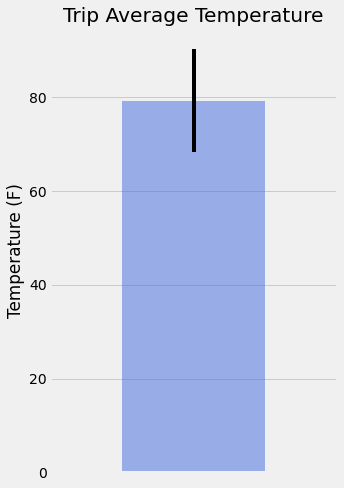

In [164]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
historical_df.plot.bar(y="Average Temperature", yerr=(historical_df["Maximum Temperature"] - historical_df["Minimum Temperature"]), 
                    title="Trip Average Temperature", color="royalblue", 
                    alpha=0.5, figsize=(5,7), legend=None)
plt.xticks([])
plt.ylabel("Temperature (F)")
plt.tight_layout()
plt.show()


### Daily Rainfall Average

In [165]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = dt.date(2017, 8, 1)
end_date = dt.date(2017, 8, 7)

sel = ([station.station, 
        station.name, 
        func.sum(measurement.prcp), 
        station.latitude, 
        station.longitude, 
        station.elevation
       ])

station_rain = (session.query(*sel)
                   .filter(station.station == measurement.station)
                   .filter(measurement.date >= start_date)
                   .filter(measurement.date <= end_date)
                   .group_by(station.station)
                   .order_by(func.sum(measurement.prcp).desc())
                   .all())

#convert query object to data frame
station_rain_df = pd.DataFrame(station_rain)
#rename columns
station_rain_df = station_rain_df.rename(columns={0: "Station", 1: "Name", 
                                                    2: "Precipitation", 3: "Latitude", 
                                                    4: "Longitude", 5: "Elevation"})
station_rain_df.set_index('Station',inplace = True)

station_rain_df_left = station_rain_df.style.set_properties(**{'text-align': 'left'})
station_rain_df_left.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

station_rain_df_left

,Name,Precipitation,Latitude,Longitude,Elevation
Station,,,,,
USC00516128,"MANOA LYON ARBO 785.2, HI US",0.360000,21.333100,-157.802500,152.400000
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.220000,21.521300,-157.837400,7.000000
USC00519281,"WAIHEE 837.5, HI US",0.060000,21.451670,-157.848890,32.900000
USC00519397,"WAIKIKI 717.2, HI US",0.040000,21.271600,-157.816800,3.000000
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.000000,21.335560,-157.711390,19.500000


### Daily Temperature Normals

In [166]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [167]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip

start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates

dates_range = pd.date_range(start_date, end_date).strftime('%Y-%m-%d')

# Strip off the year and save a list of strings in the format %m-%d

new_format_dates_range = pd.date_range(start_date, end_date).strftime('%m-%d')

new_format_dates_range

Index(['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07'], dtype='object')

In [168]:
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
# Loop through the list of %m-%d strings and calculate the normals for each date
# push each tuple of calculations into a list called `normals`

normals = []
for date in new_format_dates_range:
    normal = daily_normals(date)
    normals.append(normal)

normals

[[(67.0, 75.54, 83.0)],
 [(68.0, 75.60377358490567, 84.0)],
 [(70.0, 76.61111111111111, 85.0)],
 [(69.0, 76.71153846153847, 84.0)],
 [(69.0, 76.14814814814815, 82.0)],
 [(67.0, 76.25, 83.0)],
 [(71.0, 77.15686274509804, 83.0)]]

In [169]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

from itertools import chain

# Convert back to list (mutable) from tuple (immutable)

new_normals = [x for x in chain.from_iterable(normals)]

# Add columns names to dataframe

new_normals_df = pd.DataFrame(new_normals, columns = ['MIN TEMP', 'AVG TEMP', 'MAX TEMP'])

# Add 'Date' column to dataframe along with corresponding list 

new_normals_df['Date'] = dates_range

# Make "Date" column the index

new_normals_df.set_index('Date',inplace = True)

# Make the dataframe contents indent to left

new_normals_df_left = new_normals_df.style.set_properties(**{'text-align': 'left'})
new_normals_df_left.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

new_normals_df_left

,MIN TEMP,AVG TEMP,MAX TEMP
Date,,,
2017-08-01,67.000000,75.540000,83.000000
2017-08-02,68.000000,75.603774,84.000000
2017-08-03,70.000000,76.611111,85.000000
2017-08-04,69.000000,76.711538,84.000000
2017-08-05,69.000000,76.148148,82.000000
2017-08-06,67.000000,76.250000,83.000000
2017-08-07,71.000000,77.156863,83.000000


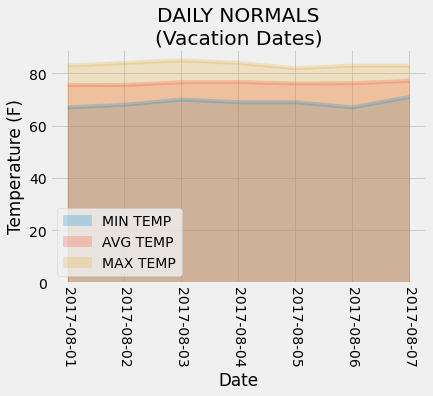

In [170]:
# Plot the daily normals as an area plot with `stacked=False`

new_normals_df.plot(kind='area', alpha=.25, stacked=False, title="DAILY NORMALS\n(Vacation Dates)")
plt.ylabel("Temperature (F)")
plt.xticks(rotation = 270)
plt.show()